# Multiple Peaks Simulations

In this set of simulations, we will test power spectrum parameterization performance across power spectra with multiple peaks.

To do so, we will simulate power spectra with a varying number of peaks with an aperiodic component in 'fixed' mode, all with varying parameters.

Performance will be evaluated by examining how well the algorithm can reconstruct the number of peaks, the aperiodic parameters, and the overall model fit.

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np

from fooof import FOOOFGroup, fit_fooof_3d
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

from sklearn.metrics import mean_squared_error, r2_score
import math
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

In [4]:
import warnings
import os
from numpy.linalg import LinAlgError
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time
import datetime
import copy
import argparse
import fooof
import math
from parameterize_spectra import *
from joblib import Parallel, delayed

## Settings

In [5]:
# Set random seed
set_random_seed(303)

In [6]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [7]:
# Set a folder name (for saving data & figures)
FOLDER = '02_multi-peak/'

In [8]:
# Data & Model Setting
GEN_SIMS = False
SAVE_SIMS = False
FIT_MODELS = False
SAVE_MODELS = False
SAVE_GTH = False

RUN_OUR_METHOD = True
SAVE_OUR_MODEL = True

In [9]:
# Run Settings
SAVE_FIG = False
PLT_LOG = True

In [10]:
# Check the conditions to simulate across: number of peaks
print('N_PEAKS: ', N_PEAKS)

N_PEAKS:  [7]


In [11]:
# Set the number of power spectra (per condition)
n_psds = N_PSDS

### Simulate Power Spectra

In [12]:
# Use generators to sample peak & aperiodic parameters
peaks = [gen_band_peak_def()]
print('Peak Definitions', peaks[0])
aps = gen_ap_def()

Peak Definitions <generator object gen_band_peak_def at 0x7f1fa29143a0>


In [13]:
# Get data sizes
n_conds = len(N_PEAKS)
print('Number of Conditions:', n_conds)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

Number of Conditions: 1


In [14]:
# Generate or load power spectra
data_name = 'multi_peak_sims_1-250_1pkperband'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_conds, n_psds, n_freqs])
    sim_params = [None] * n_conds

    # Generate simulated power spectra
    for n_ind, peaks in zip(range(n_conds), peaks):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, NLV,
                                    F_RES, return_params=True)
        
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
            
# Check shape
print('n_conds, n_spectra, n_freqs : ', psds.shape)

n_conds, n_spectra, n_freqs :  (1, 1000, 997)


In [15]:
# Extract ground truth values
_, ap_truths = get_ground_truth(sim_params)

# Save out ground truth values - added by AT
if SAVE_GTH:
    save_ground_truth(data_name, FOLDER, [], ap_truths)

# print('Peak Truths: \n', peak_truths.shape)
print('AP Truths: \n', ap_truths.shape)

AP Truths: 
 (1, 1000, 2)


### Fit Power Spectra with FOOOF

In [16]:
# Initialize FOOOFGroup to test with
fg_SpecParam = FOOOFGroup(*FOOOF_SETTINGS, verbose=False)

# Print out settings used for fitting simulated power spectra
fg_SpecParam.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 7                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [17]:
# Fit power spectra
if FIT_MODELS:
    fgs_SpecParam = fit_fooof_3d(fg_SpecParam, freqs, psds)
    
    if SAVE_MODELS:
        save_model_data(data_name, FOLDER, fgs_SpecParam)

else:
    # Reload model fit data
    fgs_SpecParam = load_model_data(data_name, FOLDER, n_conds)

### Extract FOOOF fit Data

In [18]:
# Extract data of interest from FOOOF fits
_, ap_fits_SpecParam, err_fits_SpecParam, r2_fits_SpecParam, n_fit_peaks_SpecParam = get_fit_data(fgs_SpecParam)

In [19]:
# Calculate error
ap_errors_SpecParam = np.abs(ap_truths - ap_fits_SpecParam)

In [20]:
# Pull out error per aperiodic parameter
off_errors_SpecParam = ap_errors_SpecParam[:, :, 0]
exp_errors_SpecParam = ap_errors_SpecParam[:, :, 1]

In [21]:
# Get count of relation between number of simualated and fit peaks
n_peak_counter_SpecParam = count_peak_conditions(n_fit_peaks_SpecParam, N_PEAKS)

In [22]:
n_peak_counter_SpecParam

Counter({(7, 6): 467, (7, 5): 313, (7, 7): 163, (7, 4): 57})

In [23]:
print("N_peaks", n_fit_peaks_SpecParam)

N_peaks [[6 5 4 7 6 6 6 4 6 6 6 7 6 5 6 4 7 7 6 6 6 6 6 6 5 5 5 5 6 7 6 5 4 5 7 7
  4 5 5 6 5 5 7 7 4 6 7 6 5 6 6 6 5 6 6 7 7 7 6 5 5 6 5 7 6 7 5 7 6 5 5 5
  5 7 6 6 6 7 5 5 5 5 6 5 5 6 5 6 6 7 7 6 6 4 4 5 5 7 6 6 5 7 5 6 5 5 7 6
  6 6 5 7 6 7 5 7 6 7 6 6 7 4 7 5 7 6 6 6 7 6 5 5 5 6 6 6 6 6 6 6 5 6 6 6
  5 6 6 5 5 5 6 6 5 7 6 7 5 7 6 5 5 5 4 5 5 5 6 6 6 6 6 7 5 6 4 6 6 7 6 4
  6 5 6 6 5 7 5 6 6 5 7 6 4 6 6 5 6 6 6 5 6 5 5 7 5 6 6 6 5 7 6 6 5 7 6 5
  6 5 6 6 6 4 7 6 6 7 6 6 6 5 5 6 6 6 5 7 6 7 5 5 5 6 5 5 7 7 5 5 6 6 7 5
  7 6 6 5 7 5 6 5 5 5 5 6 5 6 7 6 6 7 4 5 7 4 5 5 6 6 6 5 6 6 5 6 6 5 5 7
  5 7 7 6 7 6 6 5 6 5 5 6 7 6 6 6 7 6 4 5 6 4 5 5 5 6 6 7 6 5 5 6 6 4 6 5
  4 5 6 5 4 6 4 6 5 5 7 6 6 7 5 5 7 7 5 7 7 6 5 6 6 6 6 6 7 6 5 7 7 6 5 7
  6 6 4 4 6 6 6 6 5 5 6 7 6 5 7 5 6 7 5 5 5 6 5 6 5 6 6 6 7 5 6 5 6 5 5 6
  5 7 6 6 6 6 5 6 7 6 5 6 6 6 6 5 6 6 6 6 6 7 5 6 6 6 5 7 5 5 5 6 5 6 7 5
  5 6 5 6 5 5 6 5 6 6 6 5 5 6 5 6 5 6 6 6 5 6 6 7 5 5 6 7 6 5 6 7 5 7 6 5
  6 5 7 7 6 6 6 5 6 7 4 6 4 7 

### Check Average Errors & Stats

In [24]:
# Check overall fit quality
temp = r2_fits_SpecParam.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.9183 	0.9999
Median  R^2: 	0.9991


In [25]:
# Collect data together
datas_SpecParam = {
    'OFF' : off_errors_SpecParam,
    'EXP' : exp_errors_SpecParam,
    'ERR' : err_fits_SpecParam,
    'R^2' : r2_fits_SpecParam
}

In [26]:
# Print out the average error for each parameter, across number of peaks
#   Also prints out the average model error and R^2 per peak count
with np.printoptions(precision=4, suppress=True):
    for label, data in datas_SpecParam.items():
        print(label, '\n\t', np.nanmedian(data, 1))

OFF 
	 [0.0604]
EXP 
	 [0.0286]
ERR 
	 [0.0111]
R^2 
	 [0.9991]


### Fit Power Spectra with Our method

This part is just for testing our algorithm on a sample psd!

(997,)
(997,)
Using bands: [(1, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150), (150, 250)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 2.617417432722809, PW: 0.15157484217208256, BW: 3.120734443203742
Peak 1: CF: 6.869591031384167, PW: 0.203036092443017, BW: 1.6401405532197086
Peak 2: CF: 9.767922893256554, PW: 0.2734473428694639, BW: 1.3426926923229179
Peak 3: CF: 28.347473097807853, PW: 0.37280388282156585, BW: 1.2044541243030011
Peak 4: CF: 62.98979713544753, PW: 0.39331202072869353, BW: 1.0627405044746272
Peak 5: CF: 128.2217714124428, PW: -0.004904988264424315, BW: 1.1620259989346902
Peak 6: CF: 150.00002108205075, PW: 0.0397939678174839, BW: 1.5431956108379232
{'aperiodic_params': array([1.12885628e-01, 5.97575426e-07, 1.05454533e+00]), 'gaussian_params': array([ 0.21685118,  0.96218812,  0.56903419,  0.09708776,  1.92710457,
        0.24739097,  0.07587453,  2.27910384,  0.14733853,  0.086973  ,
        3.34453789,  0.09301323,  0.02999537,  4.14297276,  0

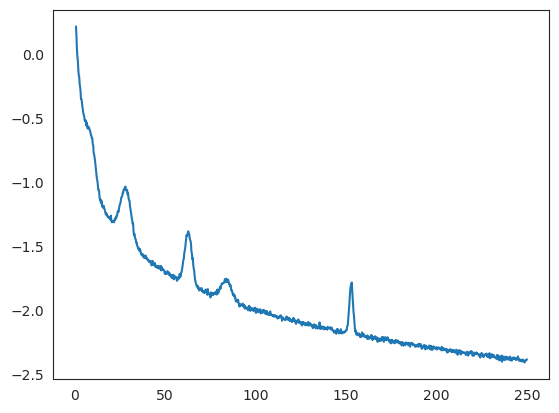

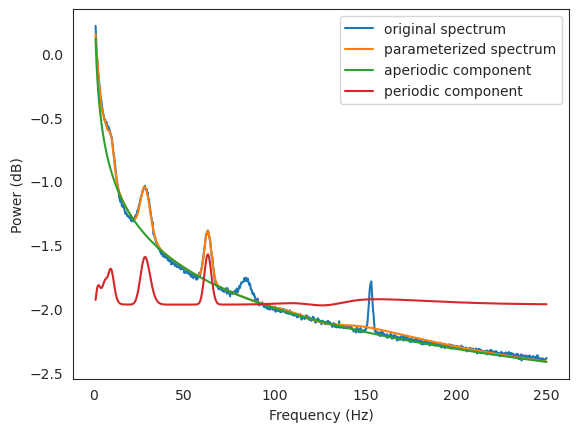

In [27]:
power_spectrum_test = psds[0, 600, :] # take the second trial
print(power_spectrum_test.shape)
print(freqs.shape)

# plot the power spectrum
plt.figure()
plt.plot(freqs, np.log10(power_spectrum_test))

param_spectra_test = ParamSpectra(bands='aila2',  max_n_peaks=7, log_freqs=True, n_division=1, l_freq=1, h_freq=250, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1)

param_spectra_test.fit(freqs, power_spectrum_test)

print(param_spectra_test)
output_params = param_spectra_test.get_params_out()
print(output_params)

plt.figure()
plt.plot(freqs, np.log10(power_spectrum_test), label='original spectrum')
plt.plot(freqs, param_spectra_test.modeled_spectrum_, label='parameterized spectrum')
plt.plot(freqs, param_spectra_test._ap_fit, label='aperiodic component')
plt.plot(freqs, param_spectra_test._peak_fit+np.mean(param_spectra_test._ap_fit), label='periodic component')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.show()

Now, let's apply our method on the whole simulated data.

In [28]:
print(psds.shape)

if RUN_OUR_METHOD:
    # define arrays to store the output parameters: aperiodic_params, peak_params, r_squared, error
    n_fitted_peaks_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1]))
    aperiodic_params_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1], 3))
    r_squared_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1]))
    error_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1]))
    param_spectra_list_ourMethod = []

    # fit and find the parameters
    for num_peaks in range(psds.shape[0]):
        for trial in range(psds.shape[1]):
            param_spectra = ParamSpectra(bands='aila2',  max_n_peaks=7, log_freqs=True, n_division=1, l_freq=1, h_freq=250, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1)
            power_spectrum_trial = psds[num_peaks, trial, :]
            param_spectra.fit(freqs, power_spectrum_trial)

            param_spectra_list_ourMethod.append(param_spectra)

            output_params = param_spectra.get_params_out()

            aperiodic_params = output_params['aperiodic_params']
            peak_params = output_params['peak_params']
            
            # reshape peak_params to be 3 columns
            peak_params = peak_params.reshape(-1, 3)
            # count the number of rows in peak_params
            n_fitted_peaks = peak_params.shape[0]

            # bring the values of peakparams to linear scale
            peak_params[0] = np.exp(peak_params[0])
            peak_params[2] = np.exp(peak_params[2])

            r_squared = output_params['r_squared']
            error = output_params['error']
            # print('aperiodic params:', aperiodic_params)
            # print('peak params:', peak_params)
            
            # storing the output parameters
            n_fitted_peaks_all_ourMethod[num_peaks, trial] = n_fitted_peaks
            aperiodic_params_all_ourMethod[num_peaks, trial, :] = aperiodic_params
            r_squared_all_ourMethod[num_peaks, trial] = r_squared
            error_all_ourMethod[num_peaks, trial] = error
        print('Fitting with num peaks:', {num_peaks})

    # save the output parameters
    if SAVE_OUR_MODEL:
        np.save('../data/02_multi-peak/n_fitted_peaks_all_multipeaks_ourMethod.npy', n_fitted_peaks_all_ourMethod)
        np.save('../data/02_multi-peak/aperiodic_params_all_multipeaks_ourMethod.npy', aperiodic_params_all_ourMethod)
        np.save('../data/02_multi-peak/r_squared_all_multipeaks_ourMethod.npy', r_squared_all_ourMethod)
        np.save('../data/02_multi-peak/error_all_multipeaks_ourMethod.npy', error_all_ourMethod)
        np.save('../data/02_multi-peak/param_spectra_list_multipeaks_ourMethod.npy', param_spectra_list_ourMethod)

else:
    # load the output parameters saved before
    n_fitted_peaks_all_ourMethod = np.load('../data/02_multi-peak/n_fitted_peaks_all_multipeaks_ourMethod.npy')
    aperiodic_params_all_ourMethod = np.load('../data/02_multi-peak/aperiodic_params_all_multipeaks_ourMethod.npy')
    r_squared_all_ourMethod = np.load('../data/02_multi-peak/r_squared_all_multipeaks_ourMethod.npy')
    error_all_ourMethod = np.load('../data/02_multi-peak/error_all_multipeaks_ourMethod.npy')
    param_spectra_list_ourMethod = np.load('../data/02_multi-peak/param_spectra_list_multipeaks_ourMethod.npy')



(1, 1000, 997)
Using bands: [(1, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150), (150, 250)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 1.2636208384065029, PW: 0.18887086398180605, BW: 2.217836204896817
Peak 1: CF: 6.043333244673416, PW: 0.19155040125014144, BW: 1.4410452008326131
Peak 2: CF: 10.928272343826112, PW: 0.24539668939265535, BW: 1.380600025236593
Peak 3: CF: 29.48098405139363, PW: 0.2485396614698101, BW: 1.0669417376484374
Peak 4: CF: 68.03829695309972, PW: 0.14628514446629826, BW: 1.0586558725385633
Peak 5: CF: 120.96521551311535, PW: 0.14759213921572223, BW: 1.0318188489749198
Peak 6: CF: 234.00376088207804, PW: 0.40067577397169285, BW: 1.026215952127374
Using bands: [(1, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150), (150, 250)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 1.9969185357782924, PW: 0.26696318053814133, BW: 3.2459563527047552
Peak 1: CF: 4.874306831503377, PW: 0.24344935886089147, BW: 1.8016537826965409
Peak 2: C

In [29]:
print(aperiodic_params_all_ourMethod.shape)
# throw away the column 1 of aperiodic_params_all
aperiodic_params_all_ourMethod = np.delete(aperiodic_params_all_ourMethod, 1, axis=2)
print(aperiodic_params_all_ourMethod.shape)
ap_fits_ourMethod = aperiodic_params_all_ourMethod
r2_fits_ourMethod = r_squared_all_ourMethod
err_fits_ourMethod = error_all_ourMethod


print('Peak Fit Results using our method:')
print(ap_fits_ourMethod.shape)
print(err_fits_ourMethod.shape)
print(r2_fits_ourMethod.shape)

(1, 1000, 3)
(1, 1000, 2)
Peak Fit Results using our method:
(1, 1000, 2)
(1, 1000)
(1, 1000)


In [30]:
# Calculate error
ap_errors_ourMethod = np.abs(ap_truths - ap_fits_ourMethod)

In [31]:
# Pull out error per aperiodic parameter
off_errors_ourMethod = ap_errors_ourMethod[:, :, 0]
exp_errors_ourMethod = ap_errors_ourMethod[:, :, 1]

In [32]:
# Get count of relation between number of simualated and fit peaks
n_peak_counter_ourMethod = count_peak_conditions(n_fitted_peaks_all_ourMethod, N_PEAKS)

In [33]:
n_peak_counter_ourMethod

Counter({(7, 7.0): 1000})

### Check Average Errors & Stats

In [34]:
# Check overall fit quality
temp = r2_fits_ourMethod.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.9716 	0.9999
Median  R^2: 	0.9990


In [35]:
# Collect data together
datas_ourMethod = {
    'OFF' : off_errors_ourMethod,
    'EXP' : exp_errors_ourMethod,
    'ERR' : err_fits_ourMethod,
    'R^2' : r2_fits_ourMethod
}

In [36]:
# Print out the average error for each parameter, across number of peaks
#   Also prints out the average model error and R^2 per peak count
with np.printoptions(precision=4, suppress=True):
    for label, data in datas_ourMethod.items():
        print(label, '\n\t', np.nanmedian(data, 1))

OFF 
	 [0.0616]
EXP 
	 [0.03]
ERR 
	 [0.0171]
R^2 
	 [0.999]


### Per-band errors in two methods:

### Starting with SpecParam

In [37]:
# Define the frequency bands
bands = [(1, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150), (150, 250)]

offset_truths = ap_truths[0, :, 0]
exp_truths = ap_truths[0, :, 1]

# Prepare lists to store RMSE and R^2 values for each band
rmse_values_SpecParam = {band: [] for band in bands}
r2_values_SpecParam = {band: [] for band in bands}
rmse_ap_values_SpecParam = {band: [] for band in bands}
rmse_per_values_SpecParam = {band: [] for band in bands}
n_iter = off_errors_SpecParam[0].shape[0]

# Iterate all trials and all frequency bands
for iter in range(n_iter):
    # extract the offset and exp for that specific iteration
    offset = offset_truths[iter]
    exp = exp_truths[iter]

    for band in bands:
        fg_SpecParam = fgs_SpecParam[0].get_fooof(iter, True)

        # Extract the frequency range and the corresponding model fit for the current band
        min_freq, max_freq = band
        band_indices = (fg_SpecParam.freqs >= min_freq) & (fg_SpecParam.freqs <= max_freq)
        
        # Get the original and model fit data within the band
        # original_power = fg.power_spectrum[band_indices]
        original_power = psds[0, iter, band_indices]
        original_power = np.log10(original_power)
        model_fit = fg_SpecParam.fooofed_spectrum_[band_indices]

        # generate the original aperiodic component using this iteration's offset and exp
        original_aperiodic = offset - np.log10(fg_SpecParam.freqs[band_indices]**exp)
        aperiodic_fit = fg_SpecParam._ap_fit[band_indices]
        
        # generate the original periodic component
        original_periodic = original_power - original_aperiodic
        periodic_fit = model_fit - aperiodic_fit

        # Compute RMSE and R^2 for the current band
        rmse = np.sqrt(mean_squared_error(original_power, model_fit))
        r2 = r2_score(original_power, model_fit)
        rmse_ap = np.sqrt(mean_squared_error(original_aperiodic, aperiodic_fit))
        rmse_per = np.sqrt(mean_squared_error(original_periodic, periodic_fit))

        # Append the results to the lists
        rmse_values_SpecParam[band].append(rmse)
        r2_values_SpecParam[band].append(r2)
        rmse_ap_values_SpecParam[band].append(rmse_ap)
        rmse_per_values_SpecParam[band].append(rmse_per)

# Compute averages and standard deviations for RMSE and R^2
rmse_means_SpecParam = [np.mean(rmse_values_SpecParam[band]) for band in bands]
rmse_stds_SpecParam = [np.std(rmse_values_SpecParam[band]) / math.sqrt(1000) for band in bands]
r2_means_SpecParam = [np.mean(r2_values_SpecParam[band]) for band in bands]
r2_stds_SpecParam = [np.std(r2_values_SpecParam[band]) / math.sqrt(1000) for band in bands]
rmse_ap_means_SpecParam = [np.mean(rmse_ap_values_SpecParam[band]) for band in bands]
rmse_ap_stds_SpecParam = [np.std(rmse_ap_values_SpecParam[band]) / math.sqrt(1000) for band in bands]
rmse_per_means_SpecParam = [np.mean(rmse_per_values_SpecParam[band]) for band in bands]
rmse_per_stds_SpecParam = [np.std(rmse_per_values_SpecParam[band]) / math.sqrt(1000) for band in bands]


This time, we're cumulating errors from all the previous bands!

In [38]:
# This time, we're cumulating the errors from all the previous bands
# Define the frequency bands
bands = [(1, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150), (150, 250)]

# Prepare lists to store RMSE and R^2 values for each band
rmse_values_cum_SpecParam = {band: [] for band in bands}
r2_values_cum_SpecParam = {band: [] for band in bands}
rmse_ap_values_cum_SpecParam = {band: [] for band in bands}
rmse_per_values_cum_SpecParam = {band: [] for band in bands}
n_iter = off_errors_SpecParam[0].shape[0]

# Iterate all trials and all frequency bands
for iter in range(n_iter):
    # extract the offset and exp for that specific iteration
    offset = offset_truths[iter]
    exp = exp_truths[iter]

    for band in bands:
        fg_SpecParam = fgs_SpecParam[0].get_fooof(iter, True)

        # Extract the frequency range and the corresponding model fit for the current band
        min_freq, max_freq = band
        band_indices_cum = (fg_SpecParam.freqs <= max_freq)

        # Get the original and model fit data within the band
        # original_power = fg.power_spectrum[band_indices]
        original_power = psds[0, iter, band_indices_cum]
        original_power = np.log10(original_power)
        model_fit = fg_SpecParam.fooofed_spectrum_[band_indices_cum]

        # generate the original aperiodic component using this iteration's offset and exp
        original_aperiodic = offset - np.log10(fg_SpecParam.freqs[band_indices_cum]**exp)
        aperiodic_fit = fg_SpecParam._ap_fit[band_indices_cum]
        
        # generate the original periodic component
        original_periodic = original_power - original_aperiodic
        periodic_fit = model_fit - aperiodic_fit

        # Compute RMSE and R^2 for the current band
        rmse = np.sqrt(mean_squared_error(original_power, model_fit))
        r2 = r2_score(original_power, model_fit)
        rmse_ap = np.sqrt(mean_squared_error(original_aperiodic, aperiodic_fit))
        rmse_per = np.sqrt(mean_squared_error(original_periodic, periodic_fit))

        # Append the results to the lists
        rmse_values_cum_SpecParam[band].append(rmse)
        r2_values_cum_SpecParam[band].append(r2)
        rmse_ap_values_cum_SpecParam[band].append(rmse_ap)
        rmse_per_values_cum_SpecParam[band].append(rmse_per)

# Compute averages and standard deviations for RMSE and R^2
rmse_means_cum_SpecParam = [np.mean(rmse_values_cum_SpecParam[band]) for band in bands]
rmse_stds_cum_SpecParam = [np.std(rmse_values_cum_SpecParam[band]) / math.sqrt(1000) for band in bands]
r2_means_cum_SpecParam = [np.mean(r2_values_cum_SpecParam[band]) for band in bands]
r2_stds_cum_SpecParam = [np.std(r2_values_cum_SpecParam[band]) / math.sqrt(1000) for band in bands]
rmse_ap_means_cum_SpecParam = [np.mean(rmse_ap_values_cum_SpecParam[band]) for band in bands]
rmse_ap_stds_cum_SpecParam = [np.std(rmse_ap_values_cum_SpecParam[band]) / math.sqrt(1000) for band in bands]
rmse_per_means_cum_SpecParam = [np.mean(rmse_per_values_cum_SpecParam[band]) for band in bands]
rmse_per_stds_cum_SpecParam = [np.std(rmse_per_values_cum_SpecParam[band]) / math.sqrt(1000) for band in bands]


### Repeating the same for our method:

In [39]:
# let's do the same thing but for our method:
# Prepare lists to store RMSE and R^2 values for each band
rmse_values_ourMethod = {band: [] for band in bands}
r2_values_ourMethod = {band: [] for band in bands}
rmse_ap_values_ourMethod = {band: [] for band in bands}
rmse_per_values_ourMethod = {band: [] for band in bands}
n_iter = off_errors_ourMethod[0].shape[0]

offset_truths = ap_truths[0, :, 0]
exp_truths = ap_truths[0, :, 1]

# Iterate all trials and all frequency bands
for iter in range(n_iter):
    # extract the offset and exp for that specific iteration
    offset = offset_truths[iter]
    exp = exp_truths[iter]

    for band in bands:
        fg_SpecParam = fgs_SpecParam[0].get_fooof(iter, True)

        # Extract the frequency range and the corresponding model fit for the current band
        min_freq, max_freq = band
        band_indices = (fg_SpecParam.freqs >= min_freq) & (fg_SpecParam.freqs <= max_freq)
        
        # Get the original and model fit data within the band
        # original_power = fg.power_spectrum[band_indices]
        original_power = psds[0, iter, band_indices]
        original_power = np.log10(original_power)
        model_fit_ourMethod = param_spectra_list_ourMethod[iter].modeled_spectrum_[band_indices]
        # print(model_fit_ours.shape)

        # generate the original aperiodic component using this iteration's offset and exp
        original_aperiodic = offset - np.log10(fg_SpecParam.freqs[band_indices]**exp)
        aperiodic_fit_ourMethod = param_spectra_list_ourMethod[iter]._ap_fit[band_indices]

        # generate the original periodic component
        original_periodic = original_power - original_aperiodic
        periodic_fit_ourMethod = model_fit_ourMethod - aperiodic_fit_ourMethod

        # Compute RMSE and R^2 for the current band
        rmse_ourMethod = np.sqrt(mean_squared_error(original_power, model_fit_ourMethod))
        r2_ourMethod = r2_score(original_power, model_fit_ourMethod)
        rmse_ap_ourMethod = np.sqrt(mean_squared_error(original_aperiodic, aperiodic_fit_ourMethod))
        rmse_per_ourMethod = np.sqrt(mean_squared_error(original_periodic, periodic_fit_ourMethod))


        # Append the results to the lists
        rmse_values_ourMethod[band].append(rmse_ourMethod)
        r2_values_ourMethod[band].append(r2_ourMethod)
        rmse_ap_values_ourMethod[band].append(rmse_ap_ourMethod)
        rmse_per_values_ourMethod[band].append(rmse_per_ourMethod)

# Compute averages and standard deviations for RMSE and R^2
rmse_means_ourMethod = [np.mean(rmse_values_ourMethod[band]) for band in bands]
rmse_stds_ourMethod = [np.std(rmse_values_ourMethod[band]) / math.sqrt(1000) for band in bands]
r2_means_ourMethod = [np.mean(r2_values_ourMethod[band]) for band in bands]
r2_stds_ourMethod = [np.std(r2_values_ourMethod[band]) / math.sqrt(1000) for band in bands]
rmse_ap_means_ourMethod = [np.mean(rmse_ap_values_ourMethod[band]) for band in bands]
rmse_ap_stds_ourMethod = [np.std(rmse_ap_values_ourMethod[band]) / math.sqrt(1000) for band in bands]
rmse_per_means_ourMethod = [np.mean(rmse_per_values_ourMethod[band]) for band in bands]
rmse_per_stds_ourMethod = [np.std(rmse_per_values_ourMethod[band]) / math.sqrt(1000) for band in bands]


This time, we're cumulating errors from all the previous bands!

In [41]:
# let's do the same thing but for our method:
# This time, we're cumulating the errors from all the previous bands

# Prepare lists to store RMSE and R^2 values for each band
rmse_values_cum_ourMethod = {band: [] for band in bands}
r2_values_cum_ourMethod = {band: [] for band in bands}
rmse_ap_values_cum_ourMethod = {band: [] for band in bands}
rmse_per_values_cum_ourMethod = {band: [] for band in bands}
n_iter = off_errors_ourMethod[0].shape[0]


offset_truths = ap_truths[0, :, 0]
exp_truths = ap_truths[0, :, 1]

# Iterate all trials and all frequency bands
for iter in range(n_iter):
    # extract the offset and exp for that specific iteration
    offset = offset_truths[iter]
    exp = exp_truths[iter]

    for band in bands:
        fg_SpecParam = fgs_SpecParam[0].get_fooof(iter, True)

        # Extract the frequency range and the corresponding model fit for the current band
        min_freq, max_freq = band
        band_indices_cum = (fg_SpecParam.freqs <= max_freq)
        
        # Get the original and model fit data within the band
        # original_power = fg.power_spectrum[band_indices]
        original_power = psds[0, iter, band_indices_cum]
        original_power = np.log10(original_power)
        model_fit_ourMethod = param_spectra_list_ourMethod[iter].modeled_spectrum_[band_indices_cum]
        # print(model_fit_ours.shape)

        # generate the original aperiodic component using this iteration's offset and exp
        original_aperiodic = offset - np.log10(fg_SpecParam.freqs[band_indices_cum]**exp)
        aperiodic_fit_ourMethod = param_spectra_list_ourMethod[iter]._ap_fit[band_indices_cum]

        # generate the original periodic component
        original_periodic = original_power - original_aperiodic
        periodic_fit_ourMethod = model_fit_ourMethod - aperiodic_fit_ourMethod

        # Compute RMSE and R^2 for the current band
        rmse_ourMethod = np.sqrt(mean_squared_error(original_power, model_fit_ourMethod))
        r2_ourMethod = r2_score(original_power, model_fit_ourMethod)
        rmse_ap_ourMethod = np.sqrt(mean_squared_error(original_aperiodic, aperiodic_fit_ourMethod))
        rmse_per_ourMethod = np.sqrt(mean_squared_error(original_periodic, periodic_fit_ourMethod))


        # Append the results to the lists
        rmse_values_cum_ourMethod[band].append(rmse_ourMethod)
        r2_values_cum_ourMethod[band].append(r2_ourMethod)
        rmse_ap_values_cum_ourMethod[band].append(rmse_ap_ourMethod)
        rmse_per_values_cum_ourMethod[band].append(rmse_per_ourMethod)

# Compute averages and standard deviations for RMSE and R^2
rmse_means_cum_ourMethod = [np.mean(rmse_values_cum_ourMethod[band]) for band in bands]
rmse_stds_cum_ourMethod = [np.std(rmse_values_cum_ourMethod[band]) / math.sqrt(1000) for band in bands]
r2_means_cum_ourMethod = [np.mean(r2_values_cum_ourMethod[band]) for band in bands]
r2_stds_cum_ourMethod = [np.std(r2_values_cum_ourMethod[band]) / math.sqrt(1000) for band in bands]
rmse_ap_means_cum_ourMethod = [np.mean(rmse_ap_values_cum_ourMethod[band]) for band in bands]
rmse_ap_stds_cum_ourMethod = [np.std(rmse_ap_values_cum_ourMethod[band]) / math.sqrt(1000) for band in bands]
rmse_per_means_cum_ourMethod = [np.mean(rmse_per_values_cum_ourMethod[band]) for band in bands]
rmse_per_stds_cum_ourMethod = [np.std(rmse_per_values_cum_ourMethod[band]) / math.sqrt(1000) for band in bands]


[1.3779143768100317e-92, 6.000980768380374e-118, 5.5680322549764694e-89, 0.37222009113474386, 0.9999998789940125, 1.0, 0.9999930119075431]
[8.26748626e-092 4.20068654e-117 2.78401613e-088 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000]


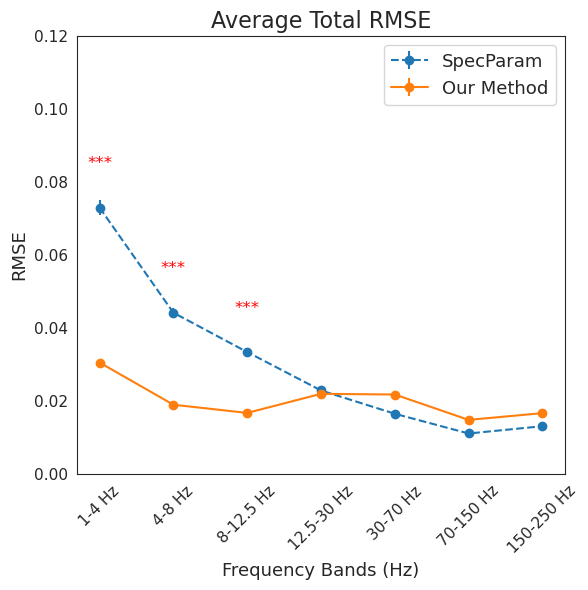

In [42]:
# Perform the Wilcoxon signed-rank test
p_values = []
for band in bands:
    stat, p = wilcoxon(rmse_values_ourMethod[band], rmse_values_SpecParam[band], alternative="less")
    p_values.append(p)
print(p_values)

# Correct for multiple comparisons using Holm-Sidak method
_, corrected_p_values, _, _ = multipletests(p_values, method='holm')

print(corrected_p_values)

# Plot the results
bands_labels = [f"{min_f}-{max_f} Hz" for min_f, max_f in bands]

plt.figure(figsize=(6, 6))

# Plot RMSE with error bars
plt.errorbar(bands_labels, rmse_means_SpecParam, yerr=rmse_stds_SpecParam, fmt='o', linestyle='--', label='SpecParam')
plt.errorbar(bands_labels, rmse_means_ourMethod, yerr=rmse_stds_ourMethod, fmt='o', linestyle='-', label='Our Method')

# Annotate significant results with stars
for i, (x, y_ours, y_specparam, p) in enumerate(zip(bands_labels, rmse_means_ourMethod, rmse_means_SpecParam, corrected_p_values)):
    if 0.01 < p < 0.05:
        # Find the higher point between the two methods for better star placement
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '*', ha='center', va='bottom', fontsize=12, color='red')
    elif 0.001 < p < 0.01:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')
    elif p < 0.001:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '***', ha='center', va='bottom', fontsize=12, color='red')

# Formatting the plot
plt.xlabel('Frequency Bands (Hz)', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.ylim(0, 0.12)
plt.legend(fontsize=13)
plt.title('Average Total RMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


[1.3779143768100317e-92, 1.725243052007623e-111, 3.391532658418335e-117, 4.3068625780607514e-58, 5.739817823528462e-08, 0.3245419317279525, 0.9999996633953316]
[6.88957188e-092 1.03514583e-110 2.37407286e-116 1.72274503e-057
 1.72194535e-007 6.49083863e-001 9.99999663e-001]


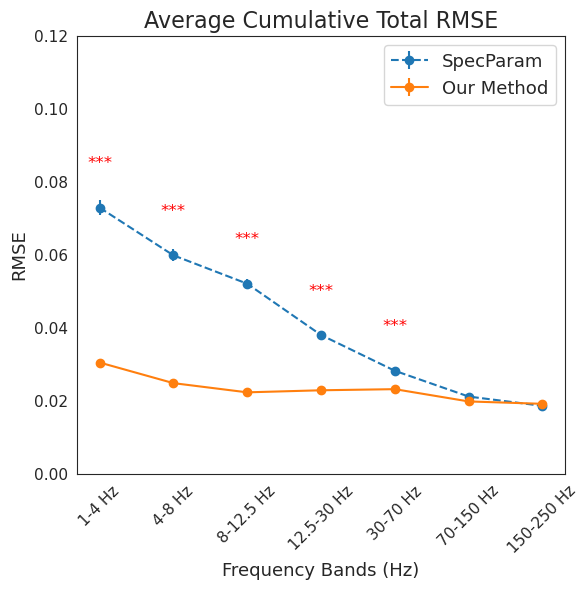

In [43]:
# Do the same but cumulatively
# Perform the Wilcoxon signed-rank test
p_values = []
for band in bands:
    stat, p = wilcoxon(rmse_values_cum_ourMethod[band], rmse_values_cum_SpecParam[band], alternative="less")
    p_values.append(p)
print(p_values)

# Correct for multiple comparisons using Holm-Sidak method
_, corrected_p_values, _, _ = multipletests(p_values, method='holm')

print(corrected_p_values)

# Plot the results
bands_labels = [f"{min_f}-{max_f} Hz" for min_f, max_f in bands]

plt.figure(figsize=(6, 6))

# Plot RMSE with error bars
plt.errorbar(bands_labels, rmse_means_cum_SpecParam, yerr=rmse_stds_cum_SpecParam, fmt='o', linestyle='--', label='SpecParam')
plt.errorbar(bands_labels, rmse_means_cum_ourMethod, yerr=rmse_stds_cum_ourMethod, fmt='o', linestyle='-', label='Our Method')

# Annotate significant results with stars
for i, (x, y_ours, y_specparam, p) in enumerate(zip(bands_labels, rmse_means_cum_ourMethod, rmse_means_cum_SpecParam, corrected_p_values)):
    if 0.01 < p < 0.05:
        # Find the higher point between the two methods for better star placement
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '*', ha='center', va='bottom', fontsize=12, color='red')
    elif 0.001 < p < 0.01:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')
    elif p < 0.001:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '***', ha='center', va='bottom', fontsize=12, color='red')

# Formatting the plot
plt.xlabel('Frequency Bands (Hz)', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.ylim(0, 0.12)
plt.legend(fontsize=13)
plt.title('Average Cumulative Total RMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


[0.9999999999999688, 0.9999999999968575, 0.9999999998431981, 0.999998957913026, 0.0004642389737136511, 1.0, 0.9999999991821983]
[1.         1.         1.         1.         0.00324967 1.
 1.        ]


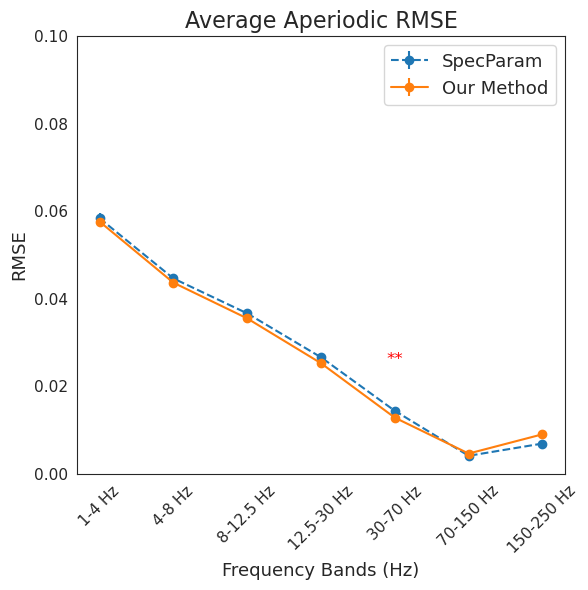

In [44]:
# Perform the Wilcoxon signed-rank test
p_values = []
for band in bands:
    stat, p = wilcoxon(rmse_ap_values_ourMethod[band], rmse_ap_values_SpecParam[band], alternative="less")
    p_values.append(p)
print(p_values)

# Correct for multiple comparisons using Holm-Sidak method
_, corrected_p_values, _, _ = multipletests(p_values, method='holm')

print(corrected_p_values)

# Plot the results
bands_labels = [f"{min_f}-{max_f} Hz" for min_f, max_f in bands]

plt.figure(figsize=(6, 6))

# Plot RMSE with error bars
plt.errorbar(bands_labels, rmse_ap_means_SpecParam, yerr=rmse_ap_stds_SpecParam, fmt='o', linestyle='--', label='SpecParam')
plt.errorbar(bands_labels, rmse_ap_means_ourMethod, yerr=rmse_ap_stds_ourMethod, fmt='o', linestyle='-', label='Our Method')

# Annotate significant results with stars
for i, (x, y_ours, y_specparam, p) in enumerate(zip(bands_labels, rmse_ap_means_ourMethod, rmse_ap_means_SpecParam, corrected_p_values)):
    if 0.01 < p < 0.05:
        # Find the higher point between the two methods for better star placement
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '*', ha='center', va='bottom', fontsize=12, color='red')
    elif 0.001 < p < 0.01:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')
    elif p < 0.001:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '***', ha='center', va='bottom', fontsize=12, color='red')

# Formatting the plot
plt.xlabel('Frequency Bands (Hz)', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.ylim(0, 0.1)
plt.legend(fontsize=13)
plt.title('Average Aperiodic RMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


[0.9999999999999688, 0.9999999999998768, 0.9999999999994464, 0.9999999999775615, 0.9999999951419508, 0.9999999995496027, 1.0]
[1. 1. 1. 1. 1. 1. 1.]


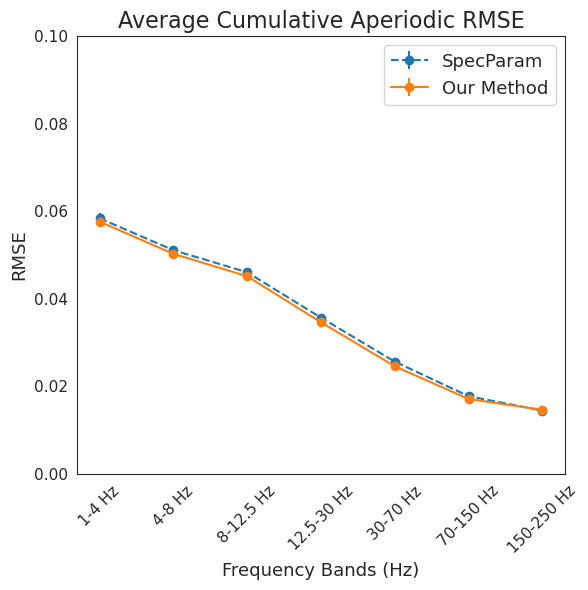

In [45]:
# Do the same but cumulatively

# Perform the Wilcoxon signed-rank test
p_values = []
for band in bands:
    stat, p = wilcoxon(rmse_ap_values_cum_ourMethod[band], rmse_ap_values_cum_SpecParam[band], alternative="less")
    p_values.append(p)
print(p_values)

# Correct for multiple comparisons using Holm-Sidak method
_, corrected_p_values, _, _ = multipletests(p_values, method='holm')

print(corrected_p_values)

# Plot the results
bands_labels = [f"{min_f}-{max_f} Hz" for min_f, max_f in bands]

plt.figure(figsize=(6, 6))

# Plot RMSE with error bars
plt.errorbar(bands_labels, rmse_ap_means_cum_SpecParam, yerr=rmse_ap_stds_cum_SpecParam, fmt='o', linestyle='--', label='SpecParam')
plt.errorbar(bands_labels, rmse_ap_means_cum_ourMethod, yerr=rmse_ap_stds_cum_ourMethod, fmt='o', linestyle='-', label='Our Method')

# Annotate significant results with stars
for i, (x, y_ours, y_specparam, p) in enumerate(zip(bands_labels, rmse_ap_means_cum_ourMethod, rmse_ap_means_cum_SpecParam, corrected_p_values)):
    if 0.01 < p < 0.05:
        # Find the higher point between the two methods for better star placement
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '*', ha='center', va='bottom', fontsize=12, color='red')
    elif 0.001 < p < 0.01:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')
    elif p < 0.001:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '***', ha='center', va='bottom', fontsize=12, color='red')

# Formatting the plot
plt.xlabel('Frequency Bands (Hz)', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.ylim(0, 0.1)
plt.legend(fontsize=13)
plt.title('Average Cumulative Aperiodic RMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

[1.7594795935198564e-43, 4.555873457872612e-13, 2.0520016588500065e-22, 1.0, 1.0, 1.0, 1.0]
[1.23163572e-42 2.27793673e-12 1.23120100e-21 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00]


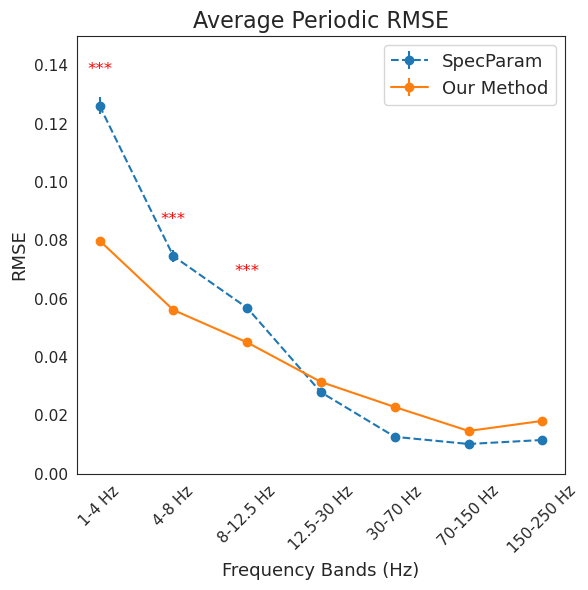

In [46]:
# Perform the Wilcoxon signed-rank test
p_values = []
for band in bands:
    stat, p = wilcoxon(rmse_per_values_ourMethod[band], rmse_per_values_SpecParam[band], alternative="less")
    p_values.append(p)

print(p_values)
# Correct for multiple comparisons using Holm-Sidak method
_, corrected_p_values, _, _ = multipletests(p_values, method='holm')

print(corrected_p_values)

# Plot the results
bands_labels = [f"{min_f}-{max_f} Hz" for min_f, max_f in bands]

plt.figure(figsize=(6, 6))

# Plot RMSE with error bars
plt.errorbar(bands_labels, rmse_per_means_SpecParam, yerr=rmse_per_stds_SpecParam, fmt='o', linestyle='--', label='SpecParam')
plt.errorbar(bands_labels, rmse_per_means_ourMethod, yerr=rmse_per_stds_ourMethod, fmt='o', linestyle='-', label='Our Method')

# Annotate significant results with stars
for i, (x, y_ours, y_specparam, p) in enumerate(zip(bands_labels, rmse_per_means_ourMethod, rmse_per_means_SpecParam, corrected_p_values)):
    if 0.01 < p < 0.05:
        # Find the higher point between the two methods for better star placement
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '*', ha='center', va='bottom', fontsize=12, color='red')
    elif 0.001 < p < 0.01:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')
    elif p < 0.001:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '***', ha='center', va='bottom', fontsize=12, color='red')

# Formatting the plot
plt.xlabel('Frequency Bands (Hz)', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.ylim(0, 0.15)
plt.legend(fontsize=13)
plt.title('Average Periodic RMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

[1.7594795935198564e-43, 2.2883651727875568e-52, 2.6101311898509647e-61, 1.4823415304419176e-28, 0.00838404226656551, 0.911947587207452, 0.9999999995772328]
[8.79739797e-43 1.37301910e-51 1.82709183e-60 5.92936612e-28
 2.51521268e-02 1.00000000e+00 1.00000000e+00]


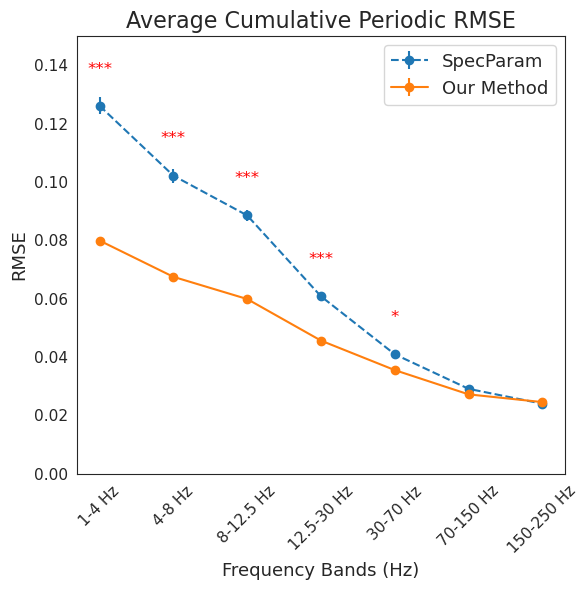

In [47]:
# Do the same but cumulatively
# Perform the Wilcoxon signed-rank test
p_values = []
for band in bands:
    stat, p = wilcoxon(rmse_per_values_cum_ourMethod[band], rmse_per_values_cum_SpecParam[band], alternative="less")
    p_values.append(p)

print(p_values)
# Correct for multiple comparisons using Holm-Sidak method
_, corrected_p_values, _, _ = multipletests(p_values, method='holm')

print(corrected_p_values)

# Plot the results
bands_labels = [f"{min_f}-{max_f} Hz" for min_f, max_f in bands]

plt.figure(figsize=(6, 6))

# Plot RMSE with error bars
plt.errorbar(bands_labels, rmse_per_means_cum_SpecParam, yerr=rmse_per_stds_cum_SpecParam, fmt='o', linestyle='--', label='SpecParam')
plt.errorbar(bands_labels, rmse_per_means_cum_ourMethod, yerr=rmse_per_stds_cum_ourMethod, fmt='o', linestyle='-', label='Our Method')

# Annotate significant results with stars
for i, (x, y_ours, y_specparam, p) in enumerate(zip(bands_labels, rmse_per_means_cum_ourMethod, rmse_per_means_cum_SpecParam, corrected_p_values)):
    if 0.01 < p < 0.05:
        # Find the higher point between the two methods for better star placement
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '*', ha='center', va='bottom', fontsize=12, color='red')
    elif 0.001 < p < 0.01:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')
    elif p < 0.001:
        y_max = max(y_ours, y_specparam)
        plt.text(i, y_max + 0.01, '***', ha='center', va='bottom', fontsize=12, color='red')

# Formatting the plot
plt.xlabel('Frequency Bands (Hz)', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.ylim(0, 0.15)
plt.legend(fontsize=13)
plt.title('Average Cumulative Periodic RMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

Plot the boxplot comparing the number of detected peaks for each method:

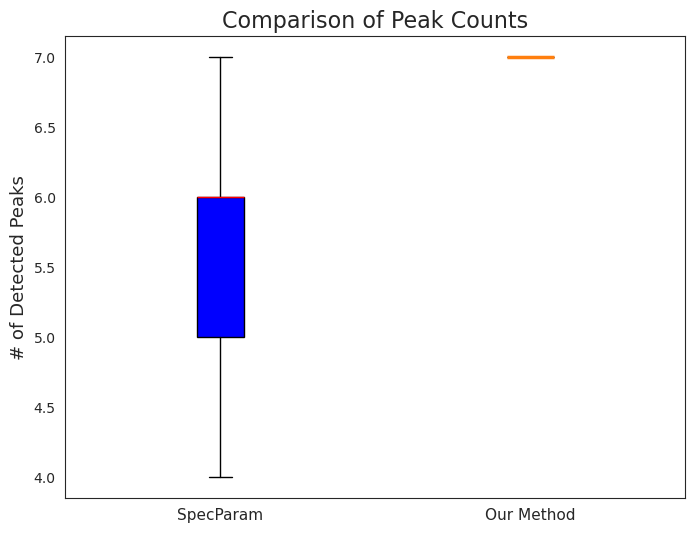

In [48]:
# Function to create data from the counters
def create_data(counter):
    values = [key[1] for key in counter.keys()]
    repetitions = [counter[key] for key in counter.keys()]
    data = []
    for value, count in zip(values, repetitions):
        data.extend([value] * count)
    return data

# Create data lists for each counter
npeak_data = create_data(n_peak_counter_SpecParam)
npeak_data_ours = create_data(n_peak_counter_ourMethod)

# Plot the box plots
plt.figure(figsize=(8, 6))
box = plt.boxplot([npeak_data, npeak_data_ours], patch_artist=True)

# Set colors for each box plot
colors = ['blue', 'C1']
for patch, color in zip(box['boxes'], colors):
    patch.set(facecolor=color)

# Modify the median line colors
for median, color in zip(box['medians'], ['red', 'C1']):
    median.set(color=color)

# Make the median line for "Our Method" thicker
box['medians'][1].set_linewidth(2.5)

# Set x-tick labels
plt.xticks([1, 2], ['SpecParam', 'Our Method'], fontsize=11)
plt.ylabel('# of Detected Peaks', fontsize=13)
plt.title('Comparison of Peak Counts', fontsize=16)
plt.show()

Plotting the same thing in another format:

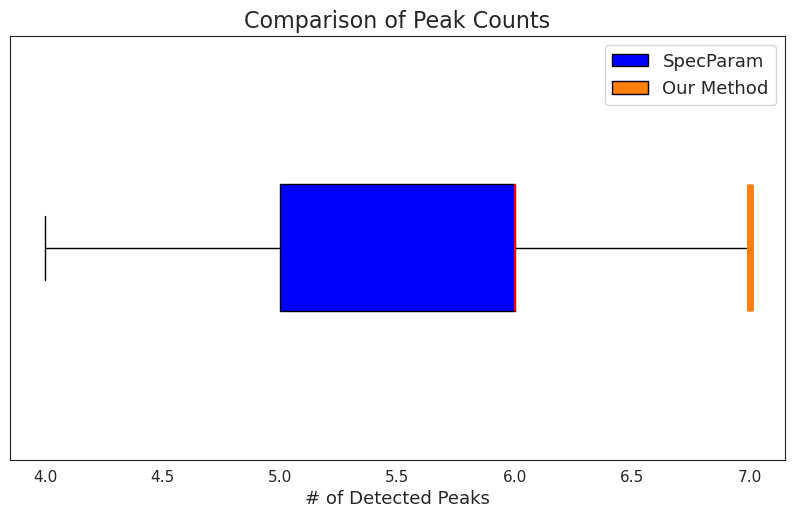

In [49]:
def create_data_3(counter):
    values = [key[1] for key in counter.keys()]
    repetitions = [counter[key] for key in counter.keys()]
    data = []
    for value, count in zip(values, repetitions):
        data.extend([value] * count)
    return data

# Create data lists for each counter
npeak_data = create_data_3(n_peak_counter_SpecParam)
npeak_data_ours = create_data_3(n_peak_counter_ourMethod)

# Plot the overlaid box plots
plt.figure(figsize=(10, 5.5))

# Plot the blue box plot for SpecParam
box1 = plt.boxplot(npeak_data, patch_artist=True, positions=[1], widths=0.3, vert=False)
box1['boxes'][0].set(facecolor='blue')
box1['medians'][0].set(color='red', linewidth=1.5)

# Plot the orange box plot for Our Method, overlaid at the same position
box2 = plt.boxplot(npeak_data_ours, patch_artist=True, positions=[1], widths=0.3, vert=False)
box2['boxes'][0].set(facecolor='#ff7f0e')  # Make it semi-transparent for clarity
box2['medians'][0].set(color='#ff7f0e', linewidth=5)  # Thicker median line

# Extend the whiskers for the orange box plot
for whisker in box2['whiskers']:
    whisker.set(color='orange', linewidth=2.5)
    
# Set x-tick labels and remove y-axis labels
plt.xlabel('# of Detected Peaks', fontsize=13)
plt.gca().get_yaxis().set_visible(False)

# Adding the legend manually
plt.legend([box1["boxes"][0], box2["boxes"][0]], ['SpecParam', 'Our Method'], loc='upper right', fontsize=13)
plt.xticks(fontsize=11)

plt.title('Comparison of Peak Counts', fontsize=16)
plt.show()

Another way of plotting the same data:

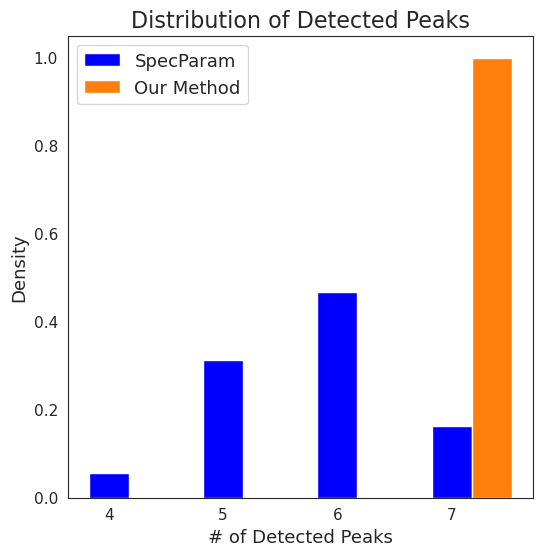

In [50]:
# Function to extract counts from the counters
def extract_counts(counter):
    counts = {}
    for key in counter.keys():
        peak_count = key[1]
        if peak_count in counts:
            counts[peak_count] += counter[key]
        else:
            counts[peak_count] = counter[key]
    return counts

# Extract counts for each method
counts_specparam = extract_counts(n_peak_counter_SpecParam)
counts_our_method = extract_counts(n_peak_counter_ourMethod)

# Get all unique peak numbers across both datasets
all_peak_numbers = sorted(set(list(counts_specparam.keys()) + list(counts_our_method.keys())))

# Prepare data for bar plot
specparam_values = np.array([counts_specparam.get(peak, 0) for peak in all_peak_numbers])/1000
our_method_values = np.array([counts_our_method.get(peak, 0) for peak in all_peak_numbers])/1000

# Set up the bar plot
bar_width = 0.35
x = np.arange(len(all_peak_numbers))

plt.figure(figsize=(6, 6))

# Plot bars for SpecParam
plt.bar(x, specparam_values, width=bar_width, color='blue', label='SpecParam')

# Plot bars for Our Method
plt.bar(x + bar_width, our_method_values, width=bar_width, color='#ff7f0e', label='Our Method')

# Adding labels and title
plt.xlabel('# of Detected Peaks', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Distribution of Detected Peaks', fontsize=16)
plt.xticks(x, all_peak_numbers, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=13)

plt.show()
